In [ ]:
!pip install datasets transformers albumentations huggingface_hub

In [3]:
import torch
with torch.no_grad():
    torch.cuda.empty_cache()

In [1]:
from datasets import load_dataset

dataset = load_dataset("jaygala223/38-cloud-train-only-v2")

f:\JAY\0.CVSSP\NeurIPS climate change workshop - cloud detection\code\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [5]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [6]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 7560
})
Dataset({
    features: ['image', 'label'],
    num_rows: 840
})


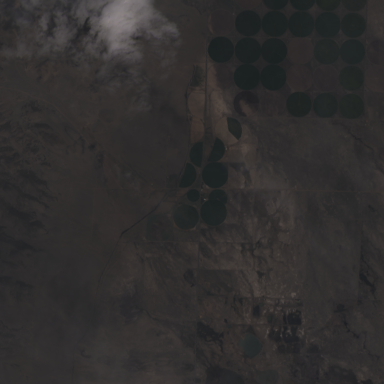

In [6]:
# let's look at one example (images are pretty high resolution)
example = train_ds[839]
image = example['image']
image

In [7]:
import numpy as np
np.array(image).shape

(384, 384, 3)

In [8]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])/255
segmentation_map = np.array(segmentation_map, dtype=np.uint8)
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [9]:
np.unique(segmentation_map)

array([0, 1], dtype=uint8)

In [7]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v2"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 1: 'cloud'}


In [8]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """

    #since we only have 2 classes
    return [[102, 255, 0], [92, 0, 255]]

palette = color_palette()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

NameError: name 'segmentation_map' is not defined

In [8]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # adding one bottom most pixel as 255 since processor/feature_extractor
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [9]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    # A.LongestMaxSize(max_size=384),
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    # A.Resize(width=100, height=100),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])
# train_dataset = ImageSegmentationDataset(train_ds)
train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)
# test_dataset = ImageSegmentationDataset(test_ds)

In [8]:
# image, segmentation_map, _, _ = train_dataset[0]
image, segmentation_map, _, _ = train_dataset[222]
print(image.shape)
print(segmentation_map.shape)

(3, 384, 384)
(384, 384)


In [10]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

# Create a preprocessor
# preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                   do_reduce_labels=False,
#                                                   do_resize=False, do_rescale=False, do_normalize=False)

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = Mask2FormerImageProcessor(ignore_index=0,
                                        do_reduce_labels=False,
                                        do_resize=False,
                                        do_rescale=False,
                                        do_normalize=True,
                                        size=size)

#my experiment
# preprocessor = Mask2FormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

In [11]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [12]:

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# batch size more than 4 causes CUDA out of memory error

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [13]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [30]:
from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic",
#                                                             id2label=id2label,
#                                                             ignore_mismatched_sizes=True)


from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("jaygala223/maskformer-finetuned-for-38-cloud-dataset",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

# load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-ade",
                                                               size={'longest_edge':384, 'shortest_edge':383},
                                                               id2label=id2label, ignore_mismatched_sizes=True)

f:\JAY\0.CVSSP\NeurIPS climate change workshop - cloud detection\code\env\lib\site-packages\transformers\models\maskformer\feature_extraction_maskformer.py:28: FutureWarning: The class MaskFormerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MaskFormerImageProcessor instead.
  warnings.warn(
f:\JAY\0.CVSSP\NeurIPS climate change workshop - cloud detection\code\env\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:411: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
f:\JAY\0.CVSSP\NeurIPS climate change workshop - cloud detection\code\env\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:418: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [16]:
import torch

def binarize_image(image, threshold = 55):
    """
    Binarizes a color image.

    Args:
        image (torch.Tensor): Input color image of shape [1, H, W, 3].
        threshold (float): Threshold value for binarization (between 0 and 255).

    Returns:
        torch.Tensor: Binarized image of shape [1, H, W].
    """
    image = image.float()
    # Convert the image to grayscale by taking the average across color channels
    gray_image = torch.mean(image, dim=3, keepdim=True)  # Shape: [1, H, W, 1]

    # Apply binarization based on the threshold
    binary_image = torch.where(gray_image >= threshold, torch.ones_like(gray_image), torch.zeros_like(gray_image))

    return binary_image.squeeze(dim=3)

In [14]:
import torch
import torch.nn as nn

class ThresholdModule(nn.Module):
    def __init__(self):
        super(ThresholdModule, self).__init__()
        # Define a fully connected layer to learn the threshold value
        self.fc = nn.Linear(3 * 384 * 384, 1)  # Input size is flattened image
        # Initialize the threshold value to a reasonable starting point
        nn.init.constant_(self.fc.weight, 0.5)  # You can adjust the initial value as needed
    
    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        # Ensure that the data type matches (e.g., float32)
        x = x.to(self.fc.weight.dtype)
        # Apply the threshold module
        threshold = torch.sigmoid(self.fc(x))  # Apply sigmoid to ensure it's in [0, 1]
        return threshold

In [22]:
threshold_module = ThresholdModule()
threshold_module.to(device)
threshold = threshold_module(images.to(device))
threshold.item()

NameError: name 'device' is not defined

In [31]:
def maskformer_forward_pass(model, feature_extractor, images, labels, device):
    inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    inputs['pixel_values'] = inputs['pixel_values'].float()

    inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    inputs['class_labels'] = torch.stack(inputs['class_labels']) 

    inputs.to(device)

    outputs = model(**inputs)
    
    return outputs

In [24]:
from torchvision.transforms import ToPILImage
import PIL.Image as Image

def display_tensor_as_pil(tensor):
    tensor = (tensor * 255).byte()

    # Convert the PyTorch tensor to a PIL image
    to_pil = ToPILImage()
    pil_image = to_pil(tensor)
    
    return pil_image

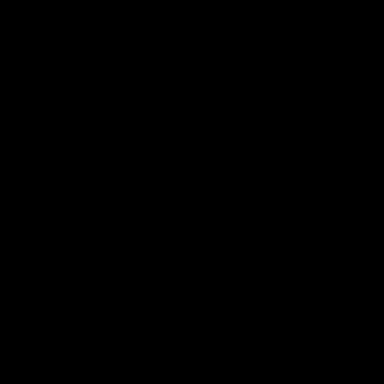

In [86]:
display_tensor_as_pil(images.permute(0, 3, 1, 2)[0]/255)

tensor(1)


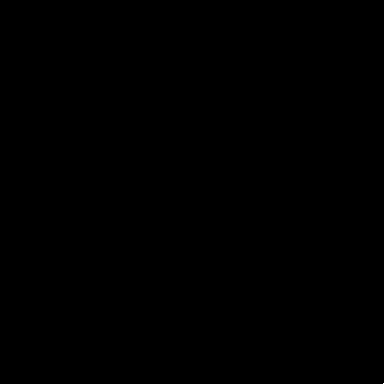

In [87]:
print(torch.sum(labels == 1))

display_tensor_as_pil(labels)

tensor(0)


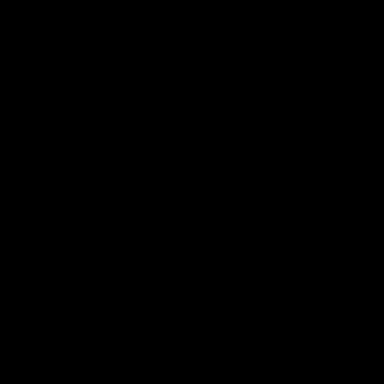

In [88]:
print(torch.sum(new_labels == 1))

display_tensor_as_pil(new_labels)

In [91]:
torch.sum(labels == 1).item()

1

In [37]:
device = "cuda"

batch = next(iter(train_dataloader))

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)
labels = np.array(labels)
labels = torch.tensor(labels)/255

print(images.shape)

images.to(device)
labels.to(device)
model.to(device)

new_labels = binarize_image(images, threshold=55)
new_labels.to(device)
# new_mask_labels = [new_labels[i].unsqueeze(dim=0).to(device) for i in range(len(batch['mask_labels']))]

# if there is only single cloud (i.e. 1) pixel then leave it
# or if all elements in new_labels are 1 then leave it (because image may have SNOW)
# note: binarization does poorly on snowy images.
# if torch.sum(labels == 1).item() == 1 or (new_labels == 1).all().item() == 1:
#     new_labels = labels

# outputs = model(batch['pixel_values'].to(device), class_labels = [(item/255).long().to(device) for item in batch['class_labels']],
#                 mask_labels = new_mask_labels)
    
outputs = maskformer_forward_pass(model, feature_extractor,images, new_labels, device)

print("done!")

torch.Size([1, 384, 384, 3])


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 6.00 GiB total capacity; 5.26 GiB already allocated; 0 bytes free; 5.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [35]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [33]:
outputs.loss

tensor([1.8247], device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
torch.cuda.empty_cache()

TRAINING

In [29]:
#LEARNABLE BINARIZATION TRAINING

import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
model.to(device)

# threshold_module = ThresholdModule()

model_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# threshold_optimizer = torch.optim.Adam(threshold_module.parameters(), lr=5e-5)
# scheduler = StepLR(optimizer, step_size=400, gamma=0.1)

running_loss = 0.0
num_samples = 0
for epoch in range(3):
  print("Epoch:", epoch)
  model.train()
  if_condition = 0
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      model_optimizer.zero_grad()
      model.to(device)
      torch.cuda.empty_cache()
      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)
      model.to(device)
#       threshold_module.to(device)
    
#       threshold = threshold_module(images.to(device))
    
      new_labels = binarize_image(images, threshold=55)
        
      # new_mask_labels = [new_labels[i].unsqueeze(dim=0).to(device) for i in range(len(batch['mask_labels']))]

      # if there is only single cloud (i.e. 1) pixel then leave it
#       if torch.sum(labels == 1).item() == 1 or (new_labels == 1).all().item() == 1:
#           new_labels = labels
#           if_condition += 1

      
      # outputs = model(batch['pixel_values'].to(device), class_labels = [(item/255).long().to(device) for item in batch['class_labels']],
      #           mask_labels = new_mask_labels)

      outputs = maskformer_forward_pass(model, feature_extractor,images, new_labels, device)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)
#         print("Threshold: ", threshold.item())
      #   print(f"if_condition executed {if_condition} times")

      # Optimization
      model_optimizer.step()
      torch.cuda.empty_cache()

Epoch: 0


  0%|          | 0/7560 [00:00<?, ?it/s]

  0%|          | 1/7560 [00:01<3:22:54,  1.61s/it]

Loss: 2.120504379272461


  0%|          | 16/7560 [02:38<20:48:36,  9.93s/it]


KeyboardInterrupt: 

In [91]:
#NORMAL TRAINING

import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=400, gamma=0.1)

running_loss = 0.0
num_samples = 0
for epoch in range(3):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)
      model.to(device)

      inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#       print(inputs)
      # comment the mask labels and class labels for segformer
      inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
      inputs['class_labels'] = torch.stack(inputs['class_labels'])
      # comment the mask labels and class labels for segformer

      inputs['pixel_values'] = inputs['pixel_values'].float()
      inputs.to(device)

      outputs = model(**inputs)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)
        if (running_loss/num_samples) <= 0.15:
          break

      # Optimization
      optimizer.step()

Epoch: 0


  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.2762831449508667
Loss: 0.433223276998442
Loss: 0.3908966482102649
Loss: 0.3794348649939745
Loss: 0.3774058534842138
Loss: 0.3843945518353054
Loss: 0.3911678305909986
Loss: 0.4002544316483101


KeyboardInterrupt: 

In [39]:
from huggingface_hub import notebook_login

notebook_login()

In [40]:
# repo_name = "<enter-model-name>-finetuned-for-38-cloud-dataset"
model.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jaygala223/segformer-finetuned-for-38-cloud-dataset/commit/fd548338bc425a43aa34e55aa97fca7d39d96bc9', commit_message='Upload SegformerForSemanticSegmentation', commit_description='', oid='fd548338bc425a43aa34e55aa97fca7d39d96bc9', pr_url=None, pr_revision=None, pr_num=None)

TESTING

In [26]:
def calculate_iou(pred_mask_list, true_mask_list):
    total_iou = 0.0
    num_masks = len(pred_mask_list)

    for pred_mask, true_mask in zip(pred_mask_list, true_mask_list):
        pred_mask = pred_mask.cpu()
        true_mask = true_mask.cpu()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()

        iou = intersection.float() / union.float()
        total_iou += iou.item()

    avg_iou = total_iou / num_masks
    return avg_iou

In [25]:
import torch

def calculate_metrics(true_labels, predicted_labels, device):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for true, predicted in zip(true_labels, predicted_labels):
        true.to(device)
        predicted.to(device)
        true_positives += torch.sum((predicted == 1) & (true == 1)).item()
        false_positives += torch.sum((predicted == 1) & (true == 0)).item()
        false_negatives += torch.sum((predicted == 0) & (true == 1)).item()
        true_negatives += torch.sum((predicted == 0) & (true == 0)).item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, accuracy, f1_score

# Example usage
true_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]
predicted_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]

precision, recall, accuracy, f1_score = calculate_metrics(true_labels, predicted_labels, "cuda")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.9999999750000006
Recall: 0.9999999750000006
Accuracy: 0.9999999833333336
F1 Score: 0.9999999250000032


In [27]:
from tqdm.auto import tqdm

model.eval()
device = "cuda"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 25:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model.to(device)

#     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
# #     print(inputs)

#     ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#     inputs['class_labels'] = torch.stack(inputs['class_labels'])
#     ##### comment these 2 lines for segformer... keep otherwise ####


#     inputs['pixel_values'] = inputs['pixel_values'].float()
#     inputs.to(device)

    # Forward pass
    with torch.no_grad():
      # outputs = model(pixel_values=pixel_values.to(device))
      new_labels = binarize_image(images, threshold=55)
        
      new_mask_labels = [new_labels[i].unsqueeze(dim=0).to(device) for i in range(len(batch['mask_labels']))]

      # if there is only single cloud (i.e. 1) pixel then leave it
#       if torch.sum(labels == 1).item() == 1 or (new_labels == 1).all().item() == 1:
#           new_labels = labels
#           if_condition += 1

      
      outputs = model(batch['pixel_values'].to(device), 
                      class_labels = [(item/255).long().to(device) for item in batch['class_labels']],
                      mask_labels = new_mask_labels)
    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = feature_extractor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)


    labels = new_labels.to(device)

    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels[i].to(device)
        labels_list.append(labels[i].to(device))

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision:", sum(precisions)/ len(precisions))
print("f1_score:", sum(f1_scores)/ len(f1_scores))
print("recall:", sum(recalls)/ len(recalls))
print("accuracy:", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/840 [00:00<?, ?it/s]

precision: 0.30147611177864164
f1_score: 0.3316069637777056
recall: 0.6153846032916235
accuracy: 0.6860888880537547
mIoU:  0.30147611003364827


In [ ]:
# BEFORE LEARNABLE BINARIZATION
precision: 0.6140759422455014
f1_score: 0.6176200393516758
recall: 0.6242902578278914
accuracy: 0.9839068029674147
mIoU:  0.5901235823447888
    
# AFTER LEARNABLE BINARIZATION


# last run
precision: 0.3062933478075279
f1_score: 0.34323185572017495
recall: 0.969535284181396
accuracy: 0.373442743152472
mIoU:  0.3061436470183687

precision 0.7754642685034004
f1_score 0.7528422777953474
recall 0.7397811585765738
accuracy 0.9775063871126577
mIoU:  0.7168471569364722

precision 0.5217402294425123
f1_score 0.5894180085336521
recall 0.999999981816197
accuracy 0.5217402294425123
mIoU:  0.521740224174788

* precision 0.3111225918183273
* f1_score 0.3191659886291905
* recall 0.3295510091217397
* accuracy 0.9829524113575062
* mIoU:  0.29805679046190703

* precision 0.26088595055841357
* f1_score 0.29013017962476445
* recall 0.3274049580908574
* accuracy 0.988511827256274
* mIoU:  0.25725841522216797

